**Como pessoa Cientista de Dados, você está encarregada pela análise do problema de precificação de quartos de hotéis, fazendo uso do conjunto de dados fornecidos. (hoteis.csv)**

Nesta atividade, sua tarefa envolve conduzir as seguintes etapas:

- Análise inicial com o PairPlot da Seaborn;
- Construir modelos de regressão linear;
- Realizar a comparação desses modelos.

In [1]:
import pandas as pd

df = pd.read_csv('hoteis.csv')
df.head()

,Estrelas,ProximidadeTurismo,Capacidade,Preco
0,5,9.301565,3,506.275452
1,1,1.785891,1,246.363458
2,4,15.504293,3,325.873550
3,4,4.173188,3,521.343284
4,4,9.443685,1,252.587087


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Estrelas            1000 non-null   int64  
 1   ProximidadeTurismo  1000 non-null   float64
 2   Capacidade          1000 non-null   int64  
 3   Preco               1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 31.4 KB


In [3]:
df.isnull().sum() # Não há dados nulos

Estrelas              0
ProximidadeTurismo    0
Capacidade            0
Preco                 0
dtype: int64

### Análise Explorátoria

In [4]:
# Cálculo da correlação
corr = df.corr()

# Exibindo a correlação do preço dos quartos
corr['Preco']

Estrelas              0.401099
ProximidadeTurismo   -0.697142
Capacidade            0.531866
Preco                 1.000000
Name: Preco, dtype: float64

<Axes: >

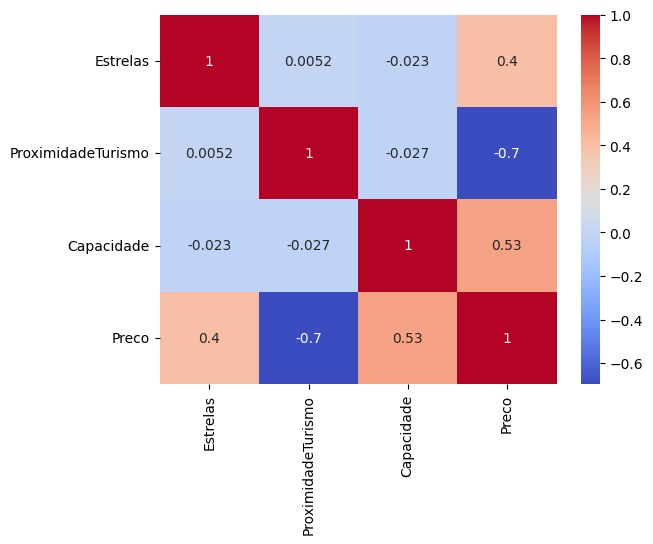

In [5]:
import seaborn as sns

# Visualização da correlação com heatmap (mapa de calor)
sns.heatmap(corr, annot=True, cmap='coolwarm')

A coluna *capacidade* mostra forte correlação com o *preço do quarto*, vamos fazer um gráfico de dispersão para analisar a relação entre essas duas variáveis. 

<Axes: xlabel='Capacidade', ylabel='Preco'>

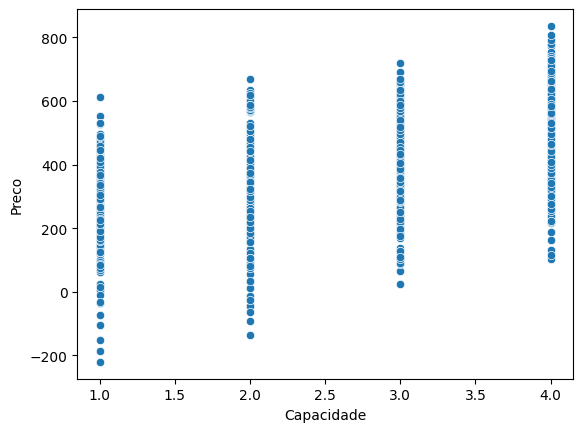

In [6]:
import matplotlib.pyplot as plt

# Gráfico de dispersão
sns.scatterplot(x=df['Capacidade'], y=df['Preco'])

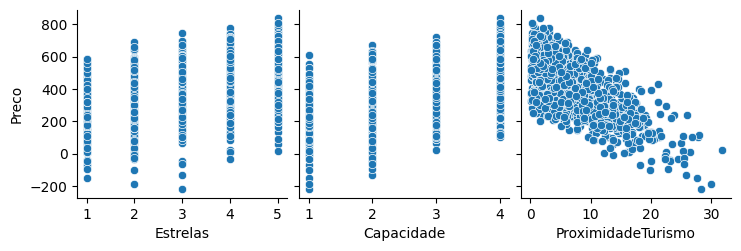

In [7]:
# Agora com pairplot
sns.pairplot(df, y_vars='Preco', x_vars=['Estrelas','Capacidade','ProximidadeTurismo'])

Text(0.5, 1.0, 'Distribuição dos Preços de Hoteis')

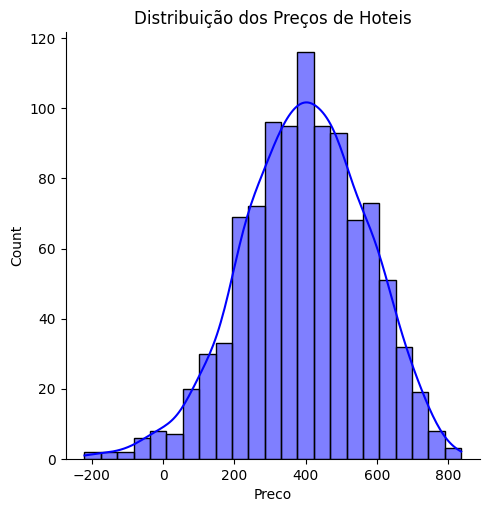

In [8]:
# Histograma para ver a distribuição do preço de quartos
sns.displot(df['Preco'], kde=True, color='blue')
plt.title("Distribuição dos Preços de Hoteis")

<Axes: >

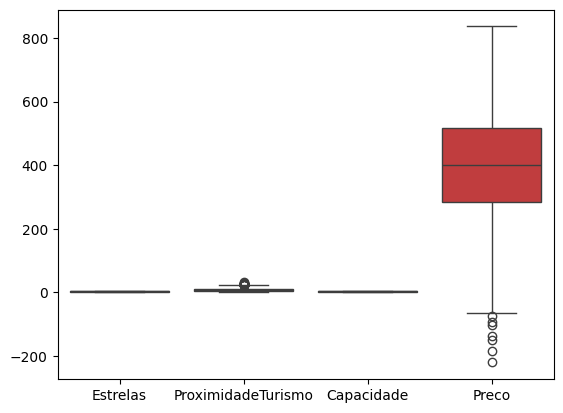

In [9]:
sns.boxplot(df)

A partir dos gráficos acima, vemos alguns valores sem sentido para a coluna "Preço", como preços de hoteis negativos.

Isto, teoricamente não existe, então vamos remover estes dados do nosso dataset.

In [10]:
# Quantidade de linhas antes da limpeza de dados
df.shape

(1000, 4)

In [11]:
# Uma query para pegar todas as linhas onde o preço é maior do que zero
df = df.query('Preco > 0')
df.shape

(984, 4)

Text(0.5, 1.0, 'Distribuição dos Preços de Hoteis')

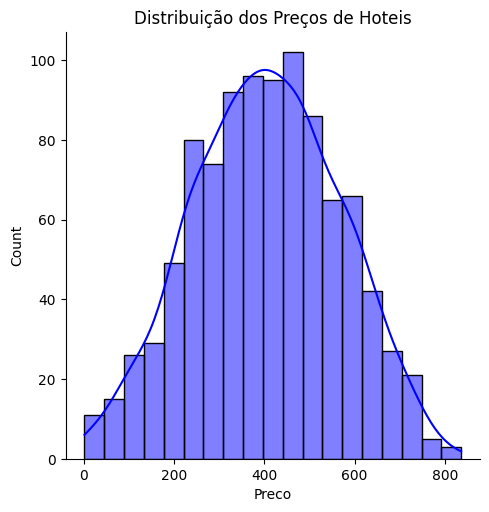

In [12]:
# Histograma novamente com o preço ajustado
sns.displot(df['Preco'], kde=True, color='blue')
plt.title("Distribuição dos Preços de Hoteis")

### Preparação para treinamento da IA

In [13]:
# Separando os rótulos (resultados) das características (variáveis explicativas)
X = df.drop('Preco', axis=1)
y = df['Preco']

In [14]:
# Dividindo os dados entre treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Treinamento da IA com **Statsmodels**

**Regressão Linear Simples**

In [15]:
# Primeiramente iremos treinar o modelo considerando apenas um dado para prever o preço (Capacidade)
from statsmodels.formula.api import ols

df_train = pd.DataFrame(X_train)
df_train['Preco'] = y_train

# Prever preço com base na Capacidade
model_formula = ols('Preco ~ Capacidade', data=df_train).fit()

In [16]:
print(model_formula.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     234.5
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           9.57e-46
Time:                        22:16:56   Log-Likelihood:                -4357.8
No. Observations:                 688   AIC:                             8720.
Df Residuals:                     686   BIC:                             8729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    222.4781     13.243     16.800      0.0

**Regressão Linear Multipla**

In [17]:
# Prever preço com base na Capacidade
model_formula = ols('Preco ~ Capacidade + Estrelas + ProximidadeTurismo', data=df_train).fit()
print(model_formula.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2360.
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:16:56   Log-Likelihood:                -3623.3
No. Observations:                 688   AIC:                             7255.
Df Residuals:                     684   BIC:                             7273.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            196.2211      6

In [18]:
import statsmodels.api as sm

# Adicionando uma constante para que seja possível o modelo encontrar um valor de y quando x for 0 (zero)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Criando o modelo de regressão de forma saturada (com todas as informações)
model_1_saturated = sm.OLS(y_train, X_train).fit()
print(model_1_saturated.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2360.
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:16:56   Log-Likelihood:                -3623.3
No. Observations:                 688   AIC:                             7255.
Df Residuals:                     684   BIC:                             7273.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                196.2211      6

Nosso modelo está apresentando um R² de 91% com os dados de treino.

Abaixo é possível observar que o R² com os dados de teste são bem próximos.

In [19]:
from sklearn.metrics import r2_score

y_predict = model_1_saturated.predict(X_test)

print(f'R²:', r2_score(y_test, y_predict))

R²: 0.9193205531042203


In [20]:
# Visualização dos parametros
model_1_saturated.params

const                 196.221061
Estrelas               50.365116
ProximidadeTurismo    -19.810121
Capacidade             79.850171
dtype: float64

<Axes: >

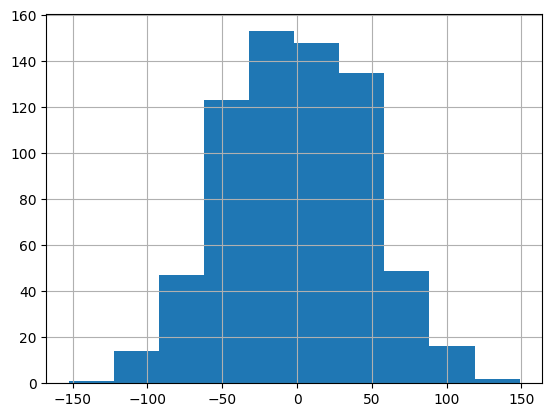

In [21]:
# Visualização dos residuos
model_1_saturated.resid.hist()

### Investigando a Multicolinearidade

Normalmente é considerado que uma variável há multicolinearidade quando o valor do VIF (fator de variação de inflação) for maior que 5.

Neste caso do nosso modelo, aparentemente não apresenta multicolinearidade.

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_model_1 = pd.DataFrame()
vif_model_1['variavel'] = X_train.columns

vif_model_1['vif'] = [variance_inflation_factor(X_train, i) for i in range(len(X_train.columns))]
vif_model_1

,variavel,vif
0,const,13.316021
1,Estrelas,1.005853
2,ProximidadeTurismo,1.001824
3,Capacidade,1.005380


### Analisando os Resíduos

Iremos visualizar os as diferenças entre os valores previstos e reais com a biblioteca *Plotly* com um gráfico de dispersão.

In [23]:
import plotly.express as px

y_predict_train = model_1_saturated.predict(X_train)

px.scatter(x=y_predict_train, y=y_train,
           title='Previsão x Real',
           trendline='ols',
           trendline_color_override='red',
           labels={'x': 'Preço previsto', 'y': 'Preço real'})

### Identificação de Homocedasticidade.
Visualização dos resíduos em relação aos valores da previsão.

Text(0, 0.5, 'Resíduos')

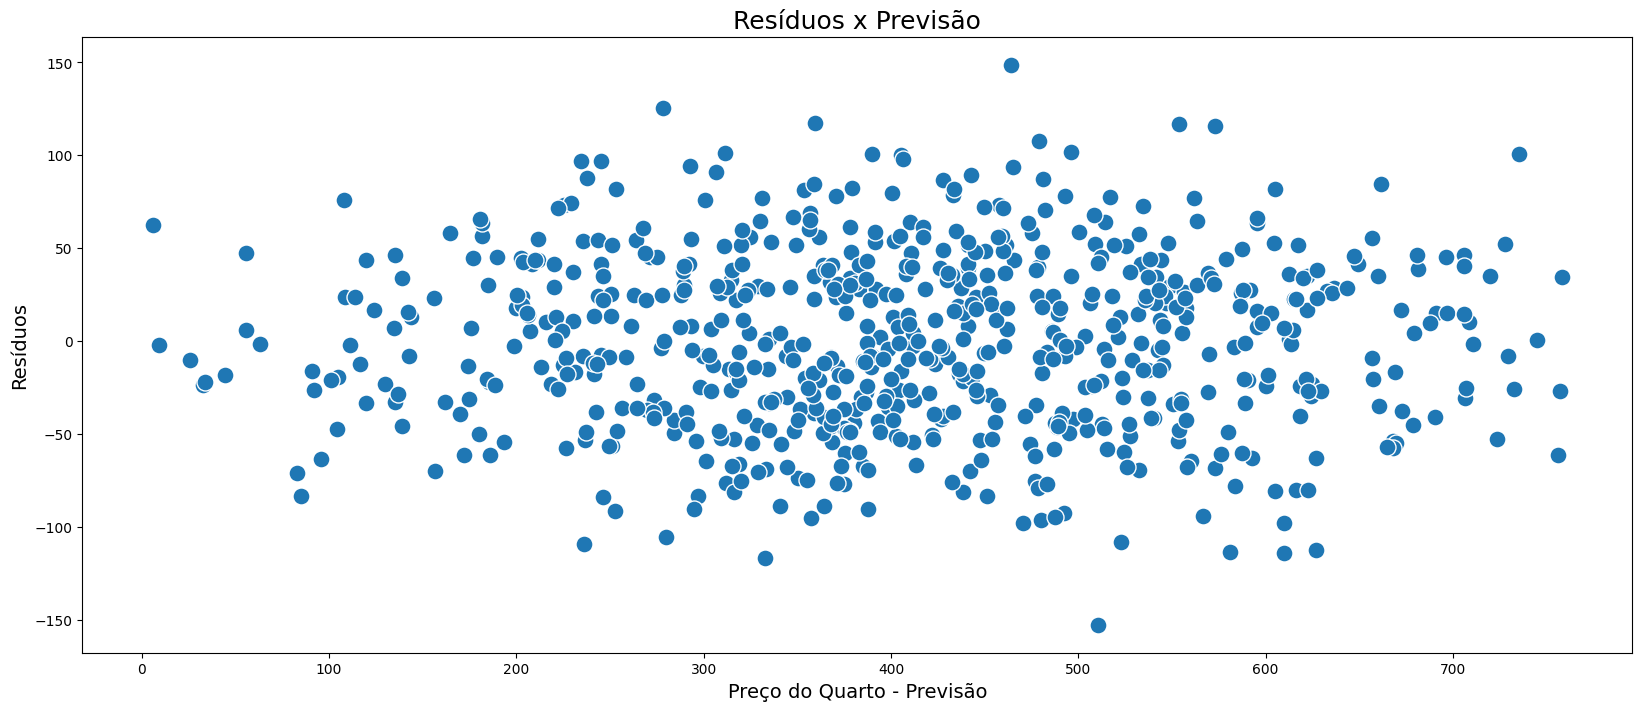

In [24]:
# s=150 aumenta o tamanho dos pontos
ax = sns.scatterplot(x=y_predict_train, y=model_1_saturated.resid, s=150)
ax.figure.set_size_inches(20,8)
ax.set_title('Resíduos x Previsão', fontsize=18)
ax.set_xlabel('Preço do Quarto - Previsão', fontsize=14)
ax.set_ylabel('Resíduos', fontsize=14)

O gráfico acima apresenta Homocedasticidade, em outras palavras, os resíduos x dados previstos estão distribuidos aleatoriamente no gráfico de dispersão e isto é exatamente o que esperamos em um modelo de Regressão Linear.